In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

# Upload the file

file_path = '/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
def read_data(filepath):
    df = pd.read_csv(filepath, header=None, names=['user-id',
                                                  'activity',
                                                  'timestamp',
                                                  'X',
                                                  'Y',
                                                  'Z'])
    # removing ';' from last column and converting it to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

# Get the file path from the uploaded dictionary

# Call the read_data() function with the file path
df = read_data(file_path)
df


,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


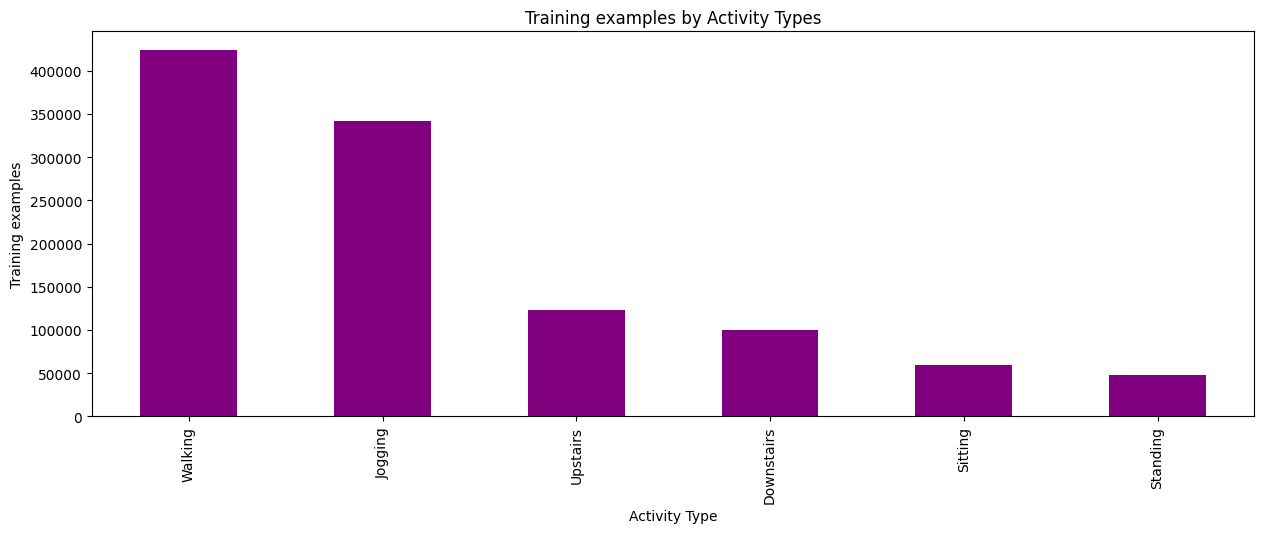

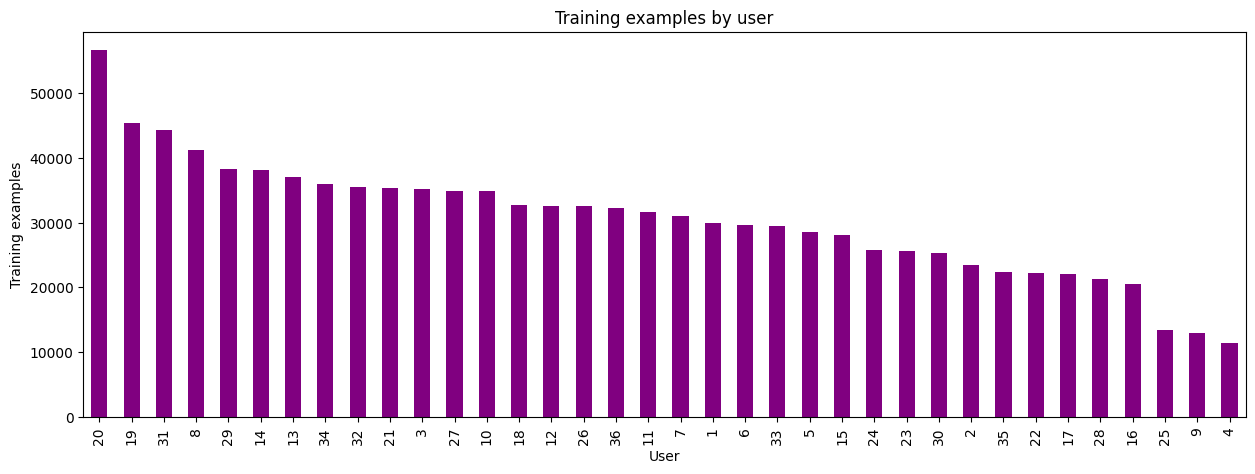

In [ ]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types', color='purple')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar',
                                 title='Training examples by user',color='purple')
plt.show()

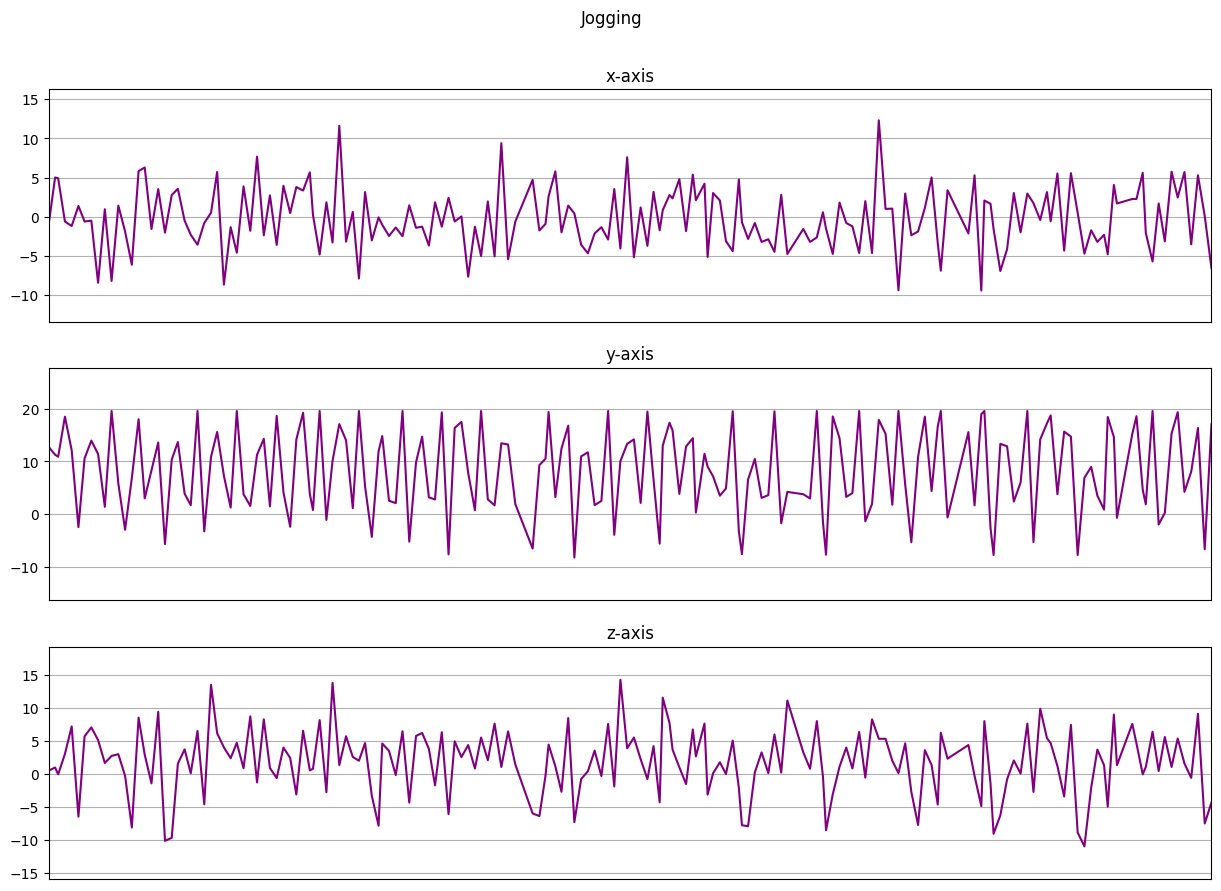

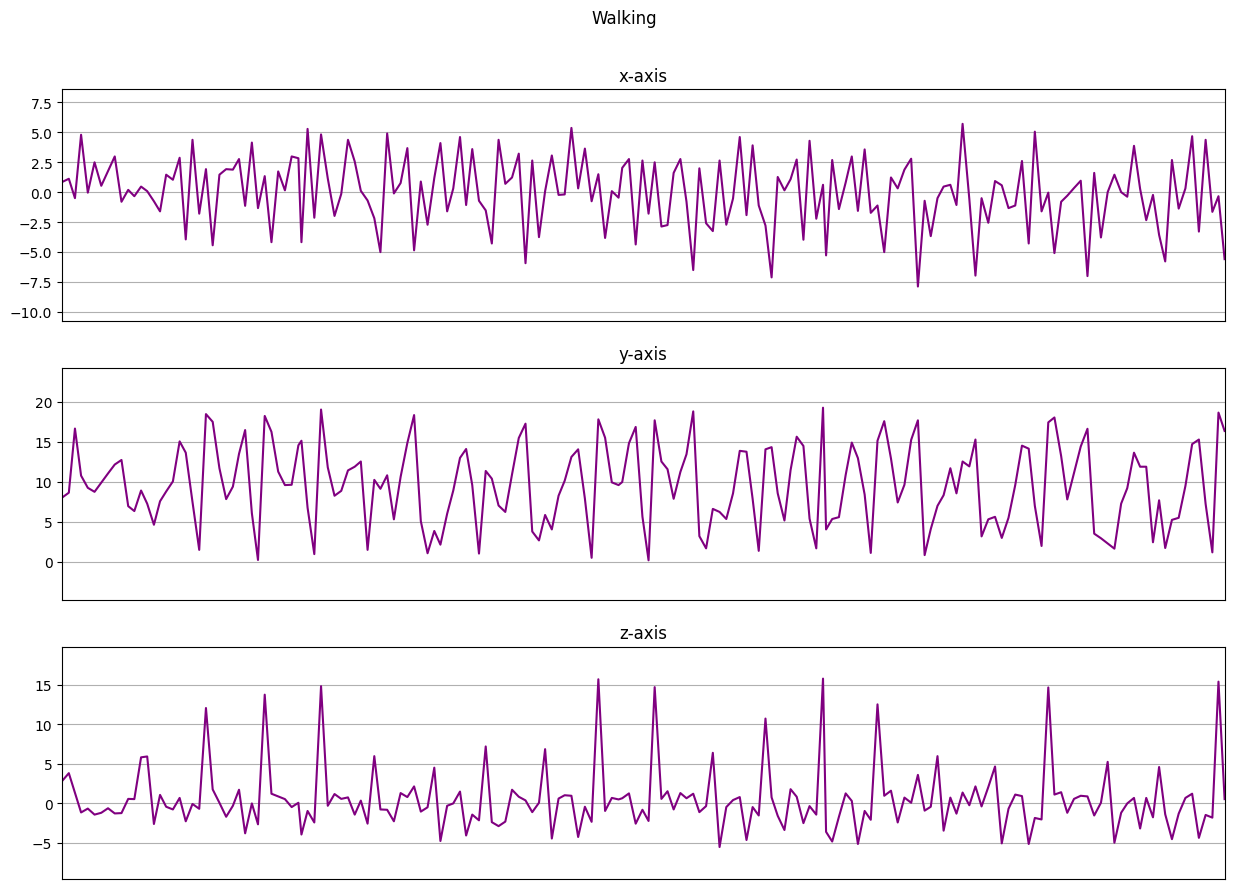

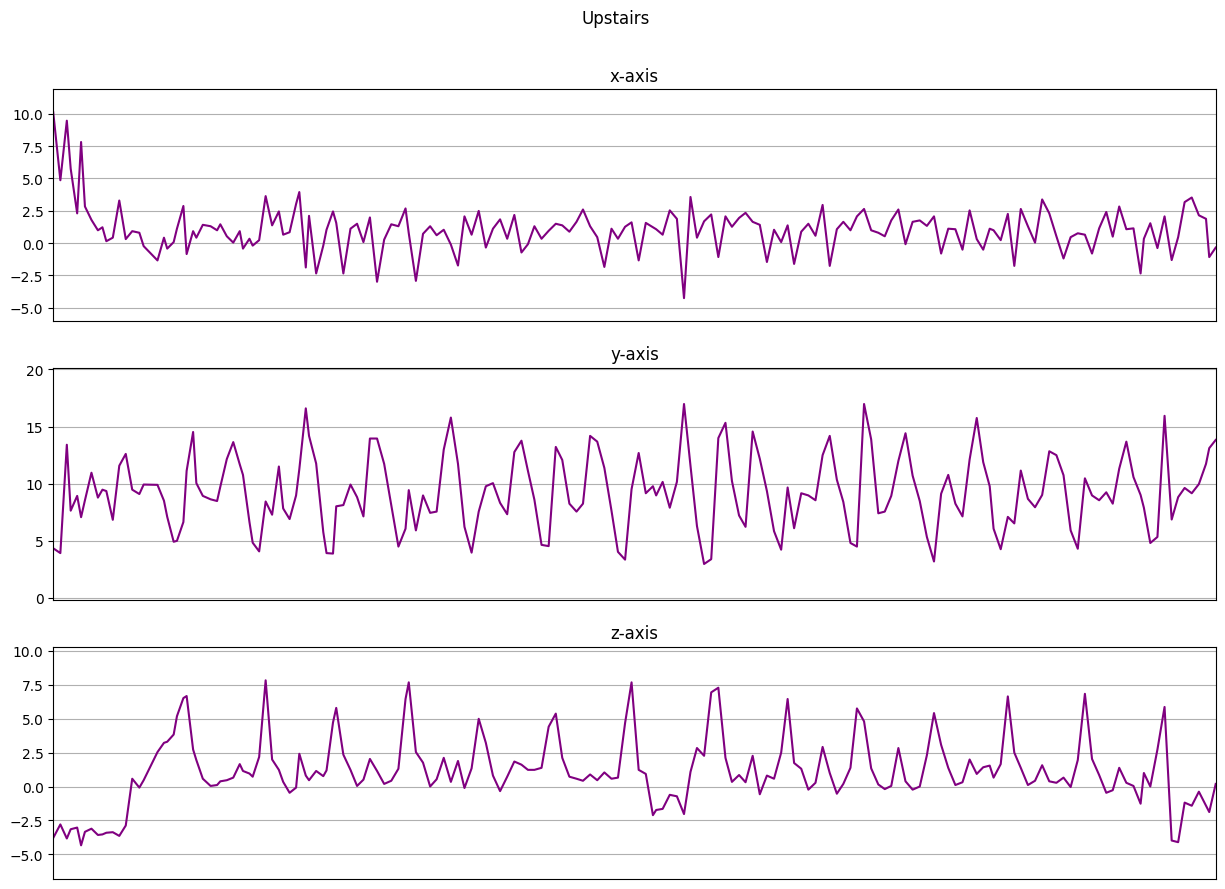

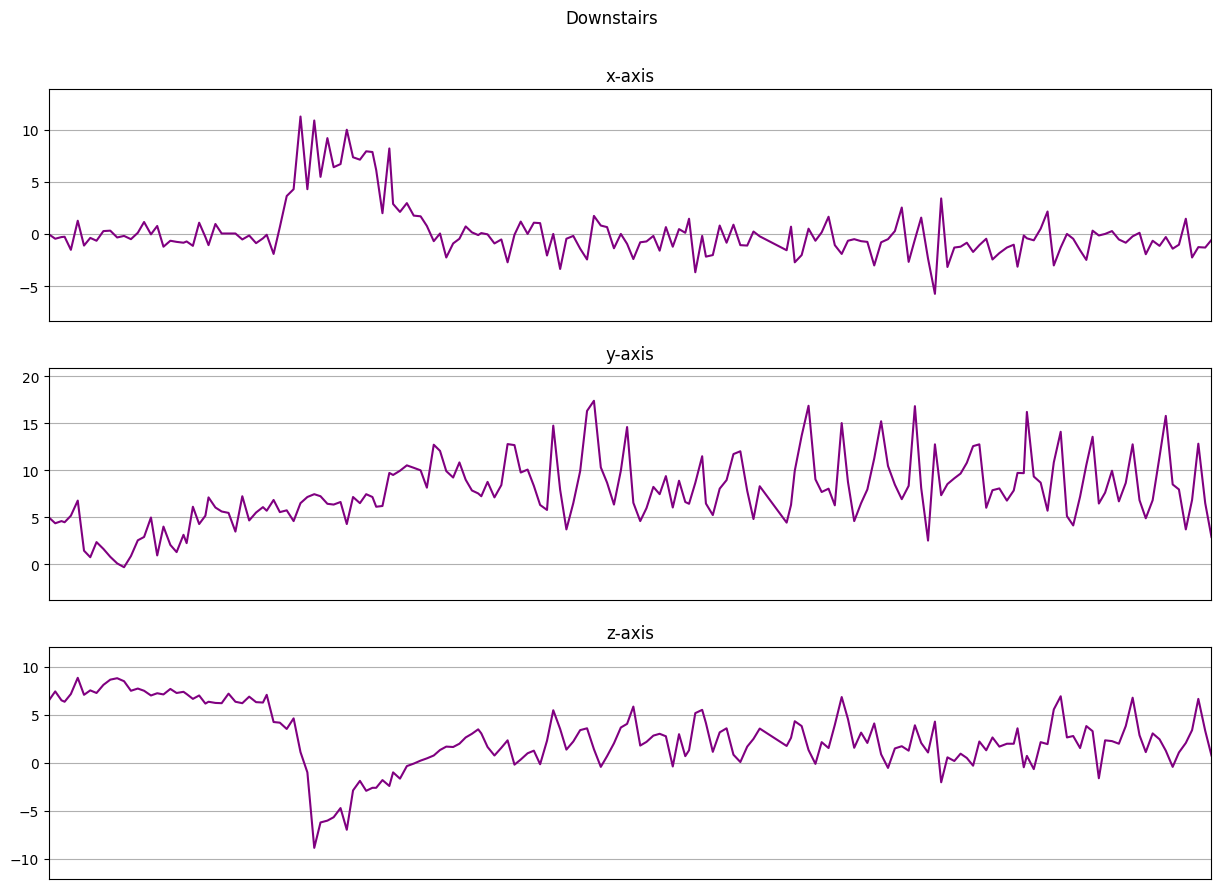

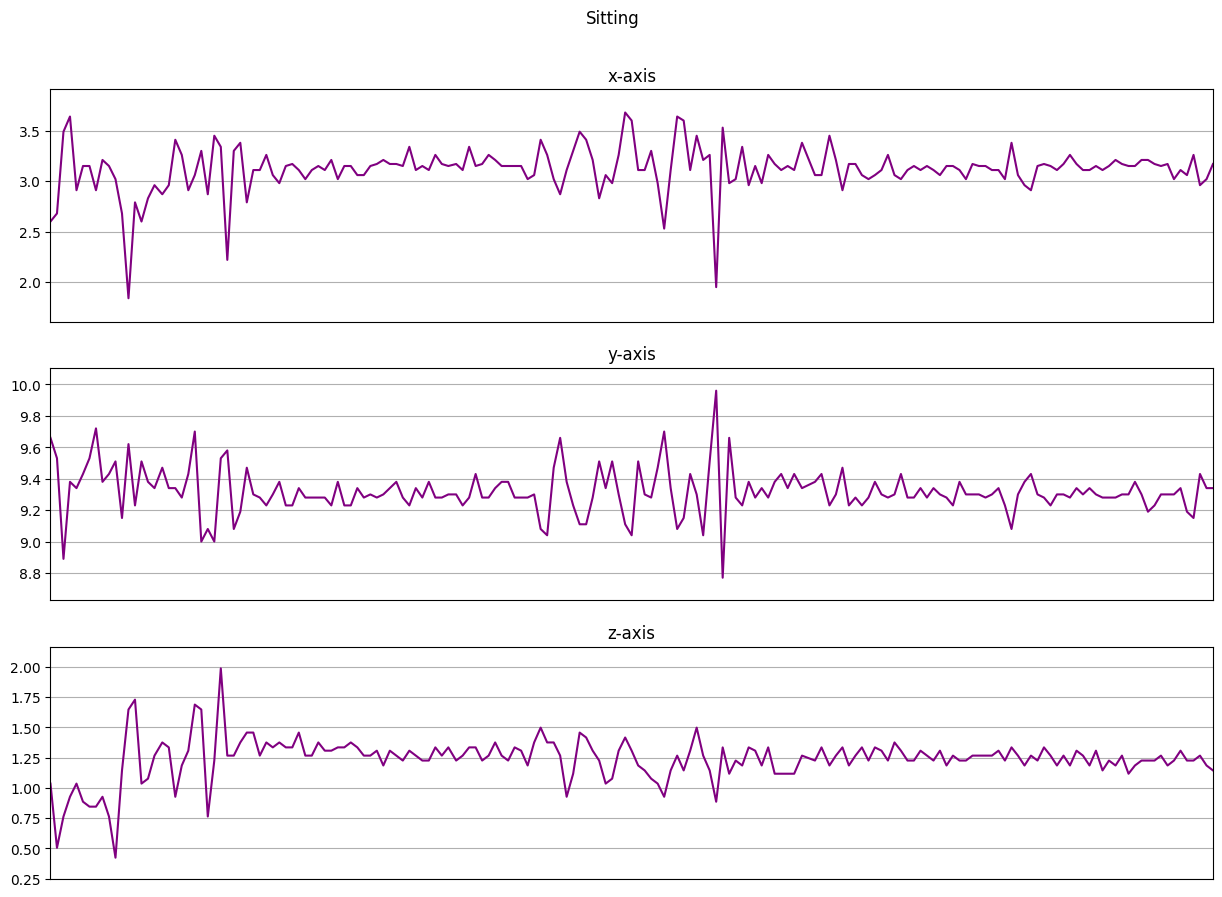

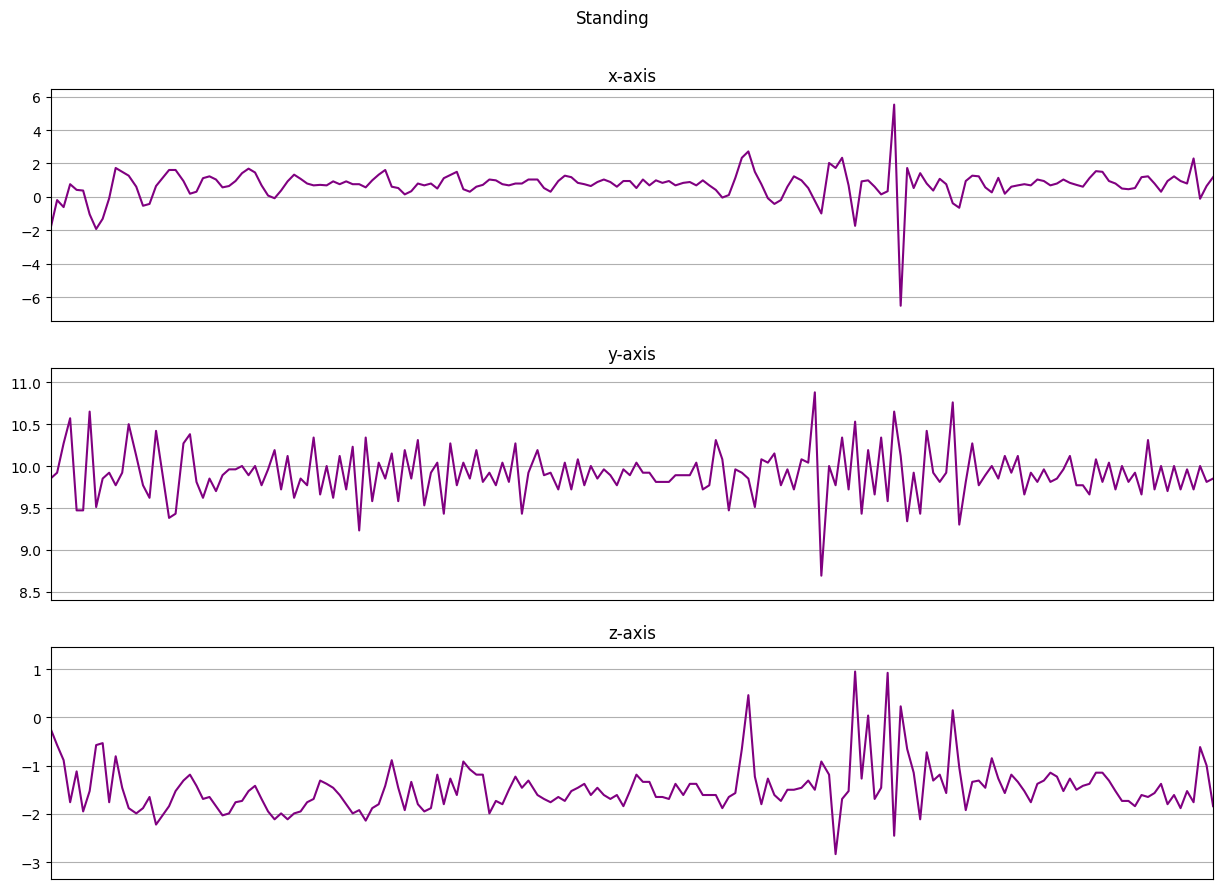

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'purple')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
#Activity label encoder
label_encode = LabelEncoder()
df['activityLabel'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityLabel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [ ]:
#Interpolation of missing values
interpolation_fn = interp1d(df['activityLabel'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityLabel'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

4.75


In [ ]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [ ]:
#Normalization
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityLabel
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098205,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098206,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098207,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [ ]:
#Segmentation
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityLabel'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [ ]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [ ]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))
print(time_period)
print(sensors)
print(num_classes)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80
3
6


In [ ]:
## reshaping data to a list
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240)


In [ ]:
# convert all the feature and label data into float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [ ]:
# One-Hot Encoding
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have completed the preprocessing steps as mentioned
# Reshape the input data
input_shape_model = (time_period * sensors, 1)  # Add 1 for the input channel dimension
x_train = x_train.reshape(x_train.shape[0], *input_shape_model)

# Convert data to float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# Perform One-Hot Encoding for the labels
num_classes = 6  # Replace with the actual number of classes in your dataset
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape:", y_train_hot.shape)

# Define the CNN-MLP model
def create_cnn_mlp_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # MLP layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Create the CNN-MLP model
model = create_cnn_mlp_model(input_shape_model, num_classes)

# Define a learning rate schedule function
def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model with an optimizer and learning rate scheduling
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Train-test split
x_train, x_test, y_train_hot, y_test = train_test_split(x_train, y_train_hot, test_size=0.2, random_state=42)

# Train the model with learning rate scheduling
batch_size = 64
epochs = 10
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
history = model.fit(x_train, y_train_hot, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[lr_scheduler])

# Evaluate the model
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_true = np.argmax(y_test, axis=1)
report = classification_report(y_test_true, predictions,digits=4)

print(report)


y_train shape: (20334, 6)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 238, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 119, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 117, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 58, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 256)           98560     
                                                                 
 max_pooling1d_2 (MaxPooling  

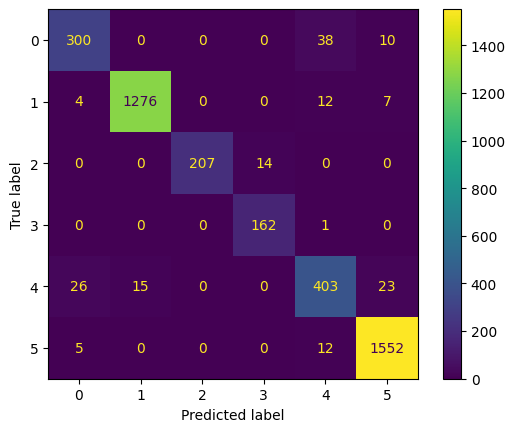

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Calculate the confusion matrix
cm = confusion_matrix(y_test_true, predictions)

# Plot the confusion matrix
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_disp.plot()

# Save the plot without displaying it
plt.savefig('CF200.png')


In [ ]:
import os
os.listdir()

['.config', 'drive', 'CF200.png', 'sample_data']